# Domain confusion calibration 域混淆校正

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import itertools
from dataPreprocess import read_dataset
from loss_functions import maximumMeanDiscrepancy
from sklearn.metrics import r2_score

In [2]:
sourceSessionIndex = 15
targetSessionIndex = 16

In [3]:
folderPath = './data'
fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('.pkl.zip')])

In [4]:
sourceSession = fileList[sourceSessionIndex]
targetSession = fileList[targetSessionIndex]

In [5]:
sourceDataset = read_dataset(os.path.join(folderPath, sourceSession), ['velocity_x', 'velocity_y'])
targetDataset = read_dataset(os.path.join(folderPath, targetSession), ['velocity_x', 'velocity_y'])

In [6]:
TRAIN_COUNT = 5000
lambda_value = 0.25

In [7]:
from model_tf import DeepDomainConfusionModel

model = DeepDomainConfusionModel(lambda_value=lambda_value)
model.compile(optimizer = 'adam', run_eagerly=True)

In [8]:
train_x = {
    'source': sourceDataset['m1'][:TRAIN_COUNT, -5:, :], 
    'target': targetDataset['m1'][:TRAIN_COUNT, -5:, :]
    }
train_y = {
    'source_movement': sourceDataset['movement'][:TRAIN_COUNT], 
    'target_movement': targetDataset['movement'][:TRAIN_COUNT]
    }

test_x = {
    'source': np.zeros_like(targetDataset['m1'][TRAIN_COUNT:, -5:, :]), 
    'target': targetDataset['m1'][TRAIN_COUNT:, -5:, :]
    }
test_y = targetDataset['movement'][TRAIN_COUNT:]

test_timestamp = targetDataset['timestamp'][TRAIN_COUNT:]

In [9]:
def run_tSNE(model, train_x):
    model.predict_movement = False
    source_features, target_features = model.predict(x=train_x)

    x = np.concatenate((source_features, target_features), axis=0)
    
    tsne = TSNE(perplexity=50, n_components=2, init='random', n_iter=1000, random_state=5, verbose=0)
    transform = tsne.fit_transform(x)

    source_features_count = len(source_features)
    transform_source = transform[:source_features_count]
    transform_target = transform[source_features_count:]

    return transform_source, transform_target

In [10]:
def train_step(model, train_dataset):
    logs = []
    for step, (x, y) in enumerate(train_dataset):      
        log = model.train_on_batch(x=x, y=y, return_dict=True)
        logs.append(log)
    
    df = pd.DataFrame(logs)   
    
    return model, df.mean()

In [11]:
df = pd.DataFrame(columns=['x', 'y', 'label', 'epoch', 'mmd', 'velocity', 'session'])

In [12]:
domain_losses = []
decode_losses = []

In [13]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

model.useTargetLabel = True
#
epochs = 2
for epoch in range(epochs):
    
    if epoch > 0:
        model, logs = train_step(model, train_dataset)

        domain_losses.append(logs['domain_loss'])
        decode_losses.append(logs['decode_loss'])

        print('epoch', epoch, 'decode_loss', logs['decode_loss'], 'domain_loss', logs['domain_loss'])
    
    # 起始的MMD
    if epoch == 0:
        model.predict_movement = False        
        source_features, target_features = model.predict(x=train_x)

        domain_loss = [maximumMeanDiscrepancy(source=source_features[i:i+128], target=target_features[i:i+128]) \
            for i in range(0, source_features.shape[0], 128)]
        domain_loss = np.mean(domain_loss)

        domain_losses.append(domain_loss)
    
    # 每 1     
    if epoch % 1 == 0:        
        # RUN TSNE 
        transform_source, transform_target = run_tSNE(model, train_x)

        # SAVE RESULTS
        df_source = pd.DataFrame({
            'x': transform_source[:, 0],
            'y': transform_source[:, 1],
            'label': 'source',
            'epoch': epoch,
            'mmd': domain_loss,  
            'velocity': np.sqrt(train_y['source_movement'][:, 0]**2 + train_y['source_movement'][:, 1]**2),             
            'session': sourceSessionIndex            
        })
        
        df_target = pd.DataFrame({
            'x': transform_target[:, 0],
            'y': transform_target[:, 1],
            'label': 'target',
            'epoch': epoch,
            'mmd': domain_loss,
            'velocity': np.sqrt(train_y['target_movement'][:, 0]**2 + train_y['target_movement'][:, 1]**2),           
            'session': targetSessionIndex            
        })

        df = pd.concat((df, df_source, df_target), axis=0)

epoch 1 decode_loss 42.663297176361084 domain_loss 0.11090418174862862


In [14]:
df

,x,y,label,epoch,mmd,velocity,session
0,17.987764,40.348404,source,0,1.208637,0.001632,15
1,17.965565,40.270138,source,0,1.208637,0.001125,15
2,-16.663967,-9.899487,source,0,1.208637,0.009670,15
3,-16.680037,-9.902113,source,0,1.208637,0.006646,15
4,-83.713196,21.262844,source,0,1.208637,0.010461,15
...,...,...,...,...,...,...,...
4995,-38.523441,34.383171,target,1,1.208637,3.347533,16
4996,-38.705147,34.379929,target,1,1.208637,2.752135,16
4997,-39.054630,34.285782,target,1,1.208637,5.203055,16
4998,-51.466499,32.636654,target,1,1.208637,5.887829,16


# 預測性能

In [15]:
model.predict_movement = True        
pred_y = model.predict(x=test_x)
r2_x = r2_score(y_pred = pred_y[:, 0], y_true = test_y[:, 0])
r2_y = r2_score(y_pred = pred_y[:, 1], y_true = test_y[:, 1])

In [16]:
'r2_x =', r2_x, 'r2_y =', r2_y

('r2_x =', 0.4507320805915551, 'r2_y =', 0.5936344869117351)

In [14]:
# df.to_csv(f'./results/tSNE/deepDomainComfuse_feature_lambda{lambda_value}.csv', index=False)

# 畫loss圖

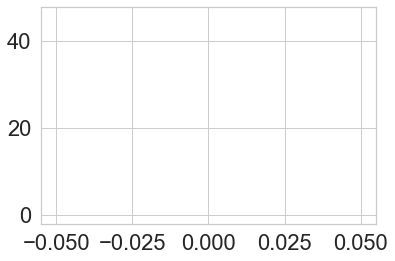

In [20]:
# loss
sns.set_theme(style='whitegrid', font_scale=2)

plt.plot(domain_losses[1:])
plt.plot(decode_losses)

# Source & Target的 embedding 在訓練中的分布情形

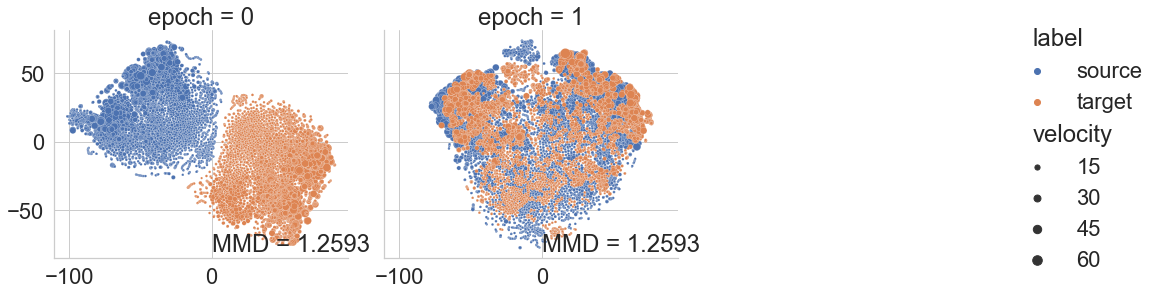

In [22]:
# tSNE 速度大小
sns.set_theme(style='whitegrid', font_scale=2)

df = df[(df['epoch'] < 18)]

g = sns.relplot(kind='scatter', data=df, x='x', y='y', hue='label', size='velocity', \
    sizes=(5, 100), col='epoch', col_wrap=3, alpha=1)

g.set(xlabel='', ylabel='')
g.axes[6].set_ylabel('feature 1')
g.axes[16].set_xlabel('feature 2')

for ax, mmd in zip(g.axes.flat, df.groupby(['epoch']).mean()['mmd'].reset_index(drop=True)):
    ax.text(0, -80, f'MMD = {mmd:.4f}', fontsize=24)